Code adapted from TensorFlow's "Image captioning with visual attention" article, specifically the "A Transformer decoder model section.
https://www.tensorflow.org/text/tutorials/image_captioning#a_transformer_decoder_model

In [170]:
import re
import string
import importlib

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pk

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from pycocotools.coco import COCO

# So we don't have to reload the notebook each time a change is made to dataset.py or model.py
import utils.model
importlib.reload(utils.model)
import utils.dataset
importlib.reload(utils.dataset)
##############################################################################################

from utils.model import SeqEmbedding, CausalSelfAttention, CrossAttention, FeedForward, DecoderLayer, TokenOutput, Captioner, GenerateText
from utils.dataset import setup_trainval_sets, standardize, load_dataset, load_image

In [171]:
# Constants for notebook
TRAIN_DATASET_PATH = "./processed_dataset/train2014_full"
VAL_DATASET_PATH = "./processed_dataset/val2014_full"
TRAIN_ANNOTATIONS_PATH = "dataset/annotations_trainval2014/captions_train2014.json"
VAL_ANNOTATIONS_PATH = "dataset/annotations_trainval2014/captions_val2014.json"

BATCH_SIZE = 256
VOCABULARY_SIZE = 10000
IMAGE_SHAPE = (224, 224, 3)

In [172]:
coco_train = COCO(TRAIN_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=1.53s)
creating index...
index created!


In [173]:
train_raw = setup_trainval_sets("train2014", coco_train)

In [174]:
for ex_path, ex_caption in train_raw.take(1):
    print("Image path:", ex_path.numpy())
    print("Caption:", ex_caption.numpy())

Image path: b'dataset/train2014/COCO_train2014_000000057870.jpg'
Caption: b'A restaurant has modern wooden tables and chairs.'


2025-01-24 18:41:39.317466: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [175]:
mobilenet = MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False, # Exclude the classification head
    weights='imagenet',
    pooling=None,
)

mobilenet.trainable=False

In [176]:
tokenizer = TextVectorization(
  max_tokens=VOCABULARY_SIZE,
  standardize=standardize,
  output_sequence_length=50,
  ragged=True
)

In [177]:
tokenizer.adapt(train_raw.map(lambda img_path, caption: caption).batch(1024))

In [178]:
tokenizer.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('a'),
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('on'),
 np.str_('of'),
 np.str_('the'),
 np.str_('in'),
 np.str_('with')]

In [179]:
t = tokenizer([['a large wooden cat'], ['a table on a hill']])

In [182]:
t

<tf.RaggedTensor [[3, 2, 29, 99, 51, 4], [3, 2, 24, 5, 2, 224, 4]]>

In [181]:
t.dtype

tf.int64

In [183]:
# Setting up data for training
train_ds = load_dataset(TRAIN_DATASET_PATH)
val_ds = load_dataset(VAL_DATASET_PATH)

In [184]:
# Sanity check for data loading
train_ds.element_spec

for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

print(ex_in_tok[0])
print(ex_labels[0])
print(ex_img[0])

(256, 7, 7, 576)
(256, 18)
(256, 18)
tf.Tensor([  3  30 190 651  10 248  20   8   2 161   0   0   0   0   0   0   0   0], shape=(18,), dtype=int64)
tf.Tensor([ 30 190 651  10 248  20   8   2 161   4   0   0   0   0   0   0   0   0], shape=(18,), dtype=int64)
tf.Tensor(
[[[-0.         -0.         -0.         ... -0.         -0.3723814
   -0.        ]
  [-0.         -0.         -0.26325056 ... -0.         -0.37417334
    2.7213187 ]
  [-0.         -0.         -0.3483031  ... -0.         -0.25607362
   -0.        ]
  ...
  [-0.16283979 -0.         -0.         ... -0.         -0.34004173
   -0.        ]
  [-0.         -0.08655853 -0.         ... -0.3732316   2.583459
    1.8625335 ]
  [-0.         -0.         -0.         ... -0.          1.8043808
    0.08865004]]

 [[-0.         -0.         -0.30955175 ... -0.         -0.
   -0.        ]
  [-0.         -0.         -0.35118377 ... -0.         -0.
    0.31250262]
  [-0.         -0.         -0.37416735 ... -0.31342405 -0.32550076
   -0.     

In [185]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████| 1618/1618 [11:07<00:00,  2.42it/s]


Uniform entropy: 9.21
Marginal entropy: 5.41


In [186]:
model = Captioner(
    tokenizer, 
    feature_extractor=mobilenet, 
    output_layer=output_layer,
    units=256, 
    dropout_rate=0.5, 
    num_layers=2, 
    num_heads=2
)

In [21]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path, IMAGE_SHAPE)

In [108]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)
  print("--------")

/home/hylke/miniconda3/envs/imagecaption/lib/python3.10/site-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'captioner_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


tf.Tensor([[3 2 2 4]], shape=(1, 4), dtype=int64)
a a
--------
tf.Tensor([[3 2 4]], shape=(1, 3), dtype=int64)
a
--------
tf.Tensor(
[[   3  326  107    2   98  181 1250   42   69  561  304  216   28  149
     4]], shape=(1, 15), dtype=int64)
cheese one a sits teddy hits black side case soccer tie person stop
--------


In [187]:
def masked_loss(labels, preds):
  labels = tf.cast(labels, tf.int32)  # Ensure labels are integers
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

In [188]:
callbacks = [
    GenerateText(IMAGE_SHAPE),
    EarlyStopping(patience=5, restore_best_weights=True)
]

In [189]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss=masked_loss, metrics=[masked_acc])

In [190]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=val_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100


/home/hylke/miniconda3/envs/imagecaption/lib/python3.10/site-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'captioner_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - loss: 5.0736 - masked_acc: 0.2188



/home/hylke/miniconda3/envs/imagecaption/lib/python3.10/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


a man on a man on a man on a
a person is in a table with the a in a
a dark meat decker round is man with computer the bike on night of a a woman street

100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 561ms/step - loss: 5.0712 - masked_acc: 0.2192 - val_loss: 4.4383 - val_masked_acc: 0.3016
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - loss: 4.3279 - masked_acc: 0.3132

a man is on a man on a
a man is on the street
an plan with out of a water is out his slope

100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 520ms/step - loss: 4.3270 - masked_acc: 0.3133 - val_loss: 4.0628 - val_masked_acc: 0.3414
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - loss: 4.0033 - masked_acc: 0.3461

a man is on a surfboard on a surfboard
a man that is sitting on a snow
two crowd in a pristine locomotive playing sign with a jacket in the other

100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 525ms/step - loss: 4.0026 - masked_acc: 0.3462 - val_loss: 3.8212 - val_masked_acc: 0.3629
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/st

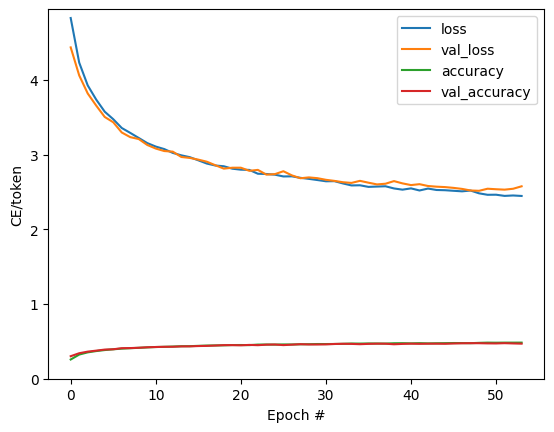

In [191]:
# Plotting
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()



In [ ]:
result = model.simple_gen(image, temperature=0.0)
result

In [ ]:
str_tokens = result.split()
str_tokens.append('[END]')

In [ ]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

In [ ]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

In [ ]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)

    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

In [ ]:
plot_attention_maps(image/255, str_tokens, attention_maps)

In [ ]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')

  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)

In [ ]:
run_and_show_attention(model, image)

In [ ]:
image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)